# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub> (Level 3).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display  
import urllib3
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component
component_nom = 'CO'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'iasi'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2019-01-01'
end_date = '2021-10-01'

# Define extent
lon_min = -25
lon_max = 45
lat_min = 30
lat_max = 70

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12')
SEARCH BOUNDING BOX
Latitudes: from 30 to 70
Longitudes: from -25 to 45


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single',
                                               CAMS_UID = None, CAMS_key = None)

2021-12-08 14:22:20,606 INFO Welcome to the CDS
2021-12-08 14:22:20,607 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
2021-12-08 14:22:20,620 INFO Request is queued


The file does not exist, it will be downloaded.


2021-12-08 14:22:21,629 INFO Request is running
2021-12-08 14:22:28,783 INFO Request is completed
2021-12-08 14:22:28,784 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data3/adaptor.mars.internal-1638973340.6530554-24276-6-7139bbb1-1e29-47b8-988d-fae199f9788d.grib to /home/alba/adc-toolbox/data/cams/CO/CO-monthly-tc-2019-01-01-2021-12-31.grib (9.9M)
2021-12-08 14:22:28,965 INFO Download rate 55M/s


In [8]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 30)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2021-06-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -24.75 -24.0 -23.25 ... 43.5 44.25 45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-08T14:22 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

In [11]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2019-01:
IASI_METOPA_L3_CO_COLUMN_201901_ULB-LATMOS_V6.5.0.nc is not available.
IASI_METOPB_L3_CO_COLUMN_201901_ULB-LATMOS_V6.5.0.nc is not available.


In [ ]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 132)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-12-01
Data variables:
    sensor_column   (time, longitude, latitude) float32 nan 0.01837 ... nan nan
    COgridNIGHT     (time, longitude, latitude) float32 nan nan ... 0.03059 nan
    ErrorgridDAY    (time, longitude, latitude) float32 nan 0.002764 ... nan nan
    ErrorgridNIGHT  (time, longitude, latitude) float32 nan nan ... 0.00268 nan
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [ ]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 132)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2008-01-01 2008-02-01 ... 2018-12-01
Data variables:
    sensor_column   (time, longitude, latitude) float64 nan 1.106e+18 ... nan
    COgridNIGHT     (time, longitude, latitude) float64 nan nan ... nan
    ErrorgridDAY    (time, longitude, latitude) float64 nan 1.664e+17 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float64 nan nan ... nan
Attributes:
    units:    molec cm-2

## 4. Match data

In [ ]:
match_table = generate_match_table(sensor_ds, model_ds, bbox,
                                   sensor, component_nom, apply_kernels)
match_table

FOR MONTH: 2008-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2008-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2008-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2008-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2008-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2008-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2008-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

,latitude,longitude,time,sensor_column,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,29.5,-25.5,2008-01-01,1.946493e+18,1.965548e+18,1.278131e+16,1.376741e+16,1.852151e+18
1,29.5,-24.5,2008-01-01,1.939168e+18,1.933659e+18,1.479310e+16,1.525139e+16,1.852151e+18
2,29.5,-23.5,2008-01-01,1.930707e+18,2.005423e+18,1.592404e+16,1.792176e+16,1.841896e+18
3,29.5,-22.5,2008-01-01,1.935818e+18,1.935605e+18,1.551402e+16,1.757771e+16,1.840537e+18
4,29.5,-21.5,2008-01-01,1.916482e+18,1.930527e+18,1.660244e+16,1.559824e+16,1.841927e+18
...,...,...,...,...,...,...,...,...
2906,69.5,40.5,2018-12-01,NaN,1.921614e+18,NaN,1.525013e+16,1.854134e+18
2907,69.5,41.5,2018-12-01,NaN,1.906463e+18,NaN,1.578483e+16,1.854617e+18
2908,69.5,42.5,2018-12-01,NaN,1.916512e+18,NaN,1.559833e+16,1.861970e+18
2909,69.5,43.5,2018-12-01,NaN,1.899962e+18,NaN,1.580246e+16,1.863306e+18


## 5. Merge data and calculate difference

In [ ]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

index  sensor_column   COgridNIGHT  \
latitude longitude time                                             
29.5     -25.5     2008-01-01      0   1.946493e+18  1.965548e+18   
         -24.5     2008-01-01      1   1.939168e+18  1.933659e+18   
         -23.5     2008-01-01      2   1.930707e+18  2.005423e+18   
         -22.5     2008-01-01      3   1.935818e+18  1.935605e+18   
         -21.5     2008-01-01      4   1.916482e+18  1.930527e+18   
...                              ...            ...           ...   
69.5      40.5     2018-12-01   2906            NaN  1.921614e+18   
          41.5     2018-12-01   2907            NaN  1.906463e+18   
          42.5     2018-12-01   2908            NaN  1.916512e+18   
          43.5     2018-12-01   2909            NaN  1.899962e+18   
          44.5     2018-12-01   2910            NaN  1.933372e+18   

                               ErrorgridDAY  ErrorgridNIGHT  model_column  \
latitude longitude time                                                     
29.5     -25.5     2008-01-01  1.278131e+16    1.376741e+16  1.852151e+18   
         -24.5     2008-01-01  1.479310e+16    1.525139e+16  1.852151e+18   
         -23.5     2008-01-01  1.592404e+16    1.792176e+16  1.841896e+18   
         -22.5     2008-01-01  1.551402e+16    1.757771e+16  1.840537e+18   
         -21.5     2008-01-01  1.660244e+16    1.559824e+16  1.841927e+18   
...                                     ...             ...           ...   
69.5      40.5     2018-12-01           NaN    1.525013e+16  1.854134e+18   
          41.5     2018-12-01           NaN    1.578483e+16  1.854617e+18   
          42.5     2018-12-01           NaN    1.559833e+16  1.861970e+18   
          43.5     2018-12-01           NaN    1.580246e+16  1.863306e+18   
          44.5     2018-12-01           NaN    1.411014e+16  1.864251e+18   

                                 difference  
latitude longitude time                      
29.5     -25.5     2008-01-01  9.434255e+16  
         -24.5     2008-01-01  8.701758e+16  
         -23.5     2008-01-01  8.881170e+16  
         -22.5     2008-01-01  9.528193e+16  
         -21.5     2008-01-01  7.455583e+16  
...                                     ...  
69.5      40.5     2018-12-01           NaN  
          41.5     2018-12-01           NaN  
          42.5     2018-12-01           NaN  
          43.5     2018-12-01           NaN  
          44.5     2018-12-01           NaN  

[384252 rows x 7 columns]

In [ ]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,index,sensor_column,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column,difference
count,384252.000000,3.824440e+05,3.753580e+05,3.824440e+05,3.753580e+05,3.842520e+05,3.824440e+05
mean,1455.000000,1.906076e+18,1.926160e+18,1.303770e+16,1.956736e+16,1.817561e+18,8.882637e+16
std,840.334361,2.406790e+17,2.595949e+17,1.002963e+16,1.620932e+16,2.315091e+17,1.580605e+17
min,0.000000,9.557126e+17,1.048458e+18,1.727555e+15,3.714445e+15,1.088954e+18,-7.915772e+18
25%,727.000000,1.734903e+18,1.743643e+18,7.326282e+15,1.197159e+16,1.640984e+18,6.823807e+15
50%,1455.000000,1.886822e+18,1.900472e+18,1.112858e+16,1.568410e+16,1.796078e+18,1.060104e+17
75%,2183.000000,2.077221e+18,2.106698e+18,1.558340e+16,2.174038e+16,1.990492e+18,1.937784e+17
max,2910.000000,4.948694e+18,5.094231e+18,3.796624e+17,4.844820e+17,1.183464e+19,1.282934e+18


## 6. Show comparison plots

### Select plot dates

In [ ]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2008-01' '2008-02' '2008-03' '2008-04' '2008-05' '2008-06' '2008-07'
 '2008-08' '2008-09' '2008-10' '2008-11' '2008-12' '2009-01' '2009-02'
 '2009-03' '2009-04' '2009-05' '2009-06' '2009-07' '2009-08' '2009-09'
 '2009-10' '2009-11' '2009-12' '2010-01' '2010-02' '2010-03' '2010-04'
 '2010-05' '2010-06' '2010-07' '2010-08' '2010-09' '2010-10' '2010-11'
 '2010-12' '2011-01' '2011-02' '2011-03' '2011-04' '2011-05' '2011-06'
 '2011-07' '2011-08' '2011-09' '2011-10' '2011-11' '2011-12' '2012-01'
 '2012-02' '2012-03' '2012-04' '2012-05' '2012-06' '2012-07' '2012-08'
 '2012-09' '2012-10' '2012-11' '2012-12' '2013-01' '2013-02' '2013-03'
 '2013-04' '2013-05' '2013-06' '2013-07' '2013-08' '2013-09' '2013-10'
 '2013-11' '2013-12' '2014-01' '2014-02' '2014-03' '2014-04' '2014-05'
 '2014-06' '2014-07' '2014-08' '2014-09' '2014-10' '2014-11' '2014-12'
 '2015-01' '2015-02' '2015-03' '2015-04' '2015-05' '2015-06' '2015-07'
 '2015-08' '2015-09' '2015-1

### Select plot extent

In [ ]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and IASI total columns

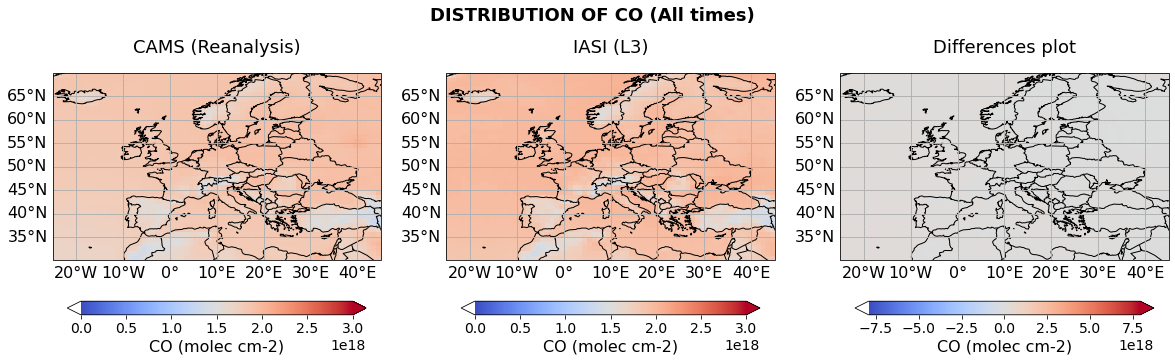

In [ ]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'aggregated'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 3*10**18

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.98, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

index  sensor_column  \
lat_search lon_search latitude longitude time                               
50         15         49.5     14.5      2008-01-01   1460   2.036513e+18   
                                         2008-02-01   1460   1.995097e+18   
                                         2008-03-01   1460   2.154884e+18   
                                         2008-04-01   1460   2.277062e+18   
                                         2008-05-01   1460   2.080821e+18   
...                                                    ...            ...   
60         30         59.5     29.5      2018-08-01   2185   2.119892e+18   
                                         2018-09-01   2185   2.170493e+18   
                                         2018-10-01   2185   1.657237e+18   
                                         2018-11-01   2185   1.643804e+18   
                                         2018-12-01   2185   1.693437e+18   

                                                      COgridNIGHT  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2008-01-01  1.901450e+18   
                                         2008-02-01  2.126184e+18   
                                         2008-03-01  2.261944e+18   
                                         2008-04-01  2.266122e+18   
                                         2008-05-01  2.233820e+18   
...                                                           ...   
60         30         59.5     29.5      2018-08-01  2.259663e+18   
                                         2018-09-01  2.155676e+18   
                                         2018-10-01  1.676514e+18   
                                         2018-11-01  1.617261e+18   
                                         2018-12-01  1.709288e+18   

                                                     ErrorgridDAY  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2008-01-01  2.569851e+16   
                                         2008-02-01  1.306474e+16   
                                         2008-03-01  1.496175e+16   
                                         2008-04-01  1.078202e+16   
                                         2008-05-01  7.891306e+15   
...                                                           ...   
60         30         59.5     29.5      2018-08-01  7.123391e+15   
                                         2018-09-01  1.110116e+16   
                                         2018-10-01  1.494882e+16   
                                         2018-11-01  3.734368e+16   
                                         2018-12-01  5.778649e+16   

                                                     ErrorgridNIGHT  \
lat_search lon_search latitude longitude time                         
50         15         49.5     14.5      2008-01-01    2.712808e+16   
                                         2008-02-01    1.861978e+16   
                                         2008-03-01    2.101280e+16   
                                         2008-04-01    1.661079e+16   
                                         2008-05-01    2.397498e+16   
...                                                             ...   
60         30         59.5     29.5      2018-08-01    1.596269e+16   
                                         2018-09-01    1.762368e+16   
                                         2018-10-01    2.135905e+16   
                                         2018-11-01    4.121812e+16   
                                         2018-12-01    9.864030e+16   

                                                     model_column  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2008-01-01  2.068100e+18   
                                         2008-02-01  2.125096e+18   
                                         2008-03-01  2.

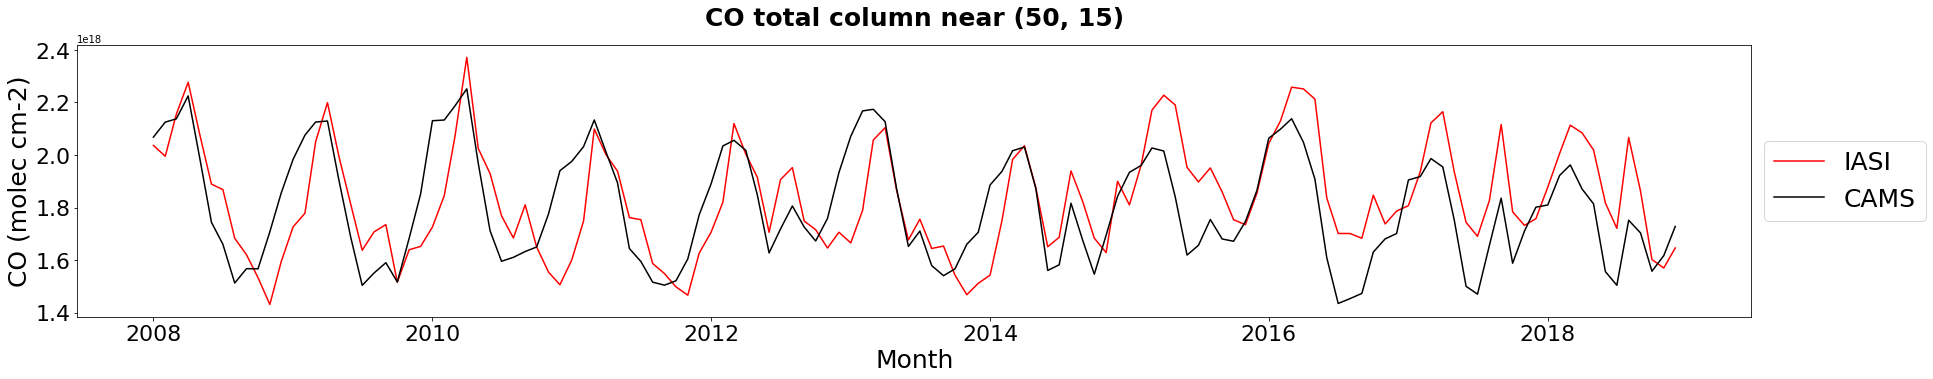

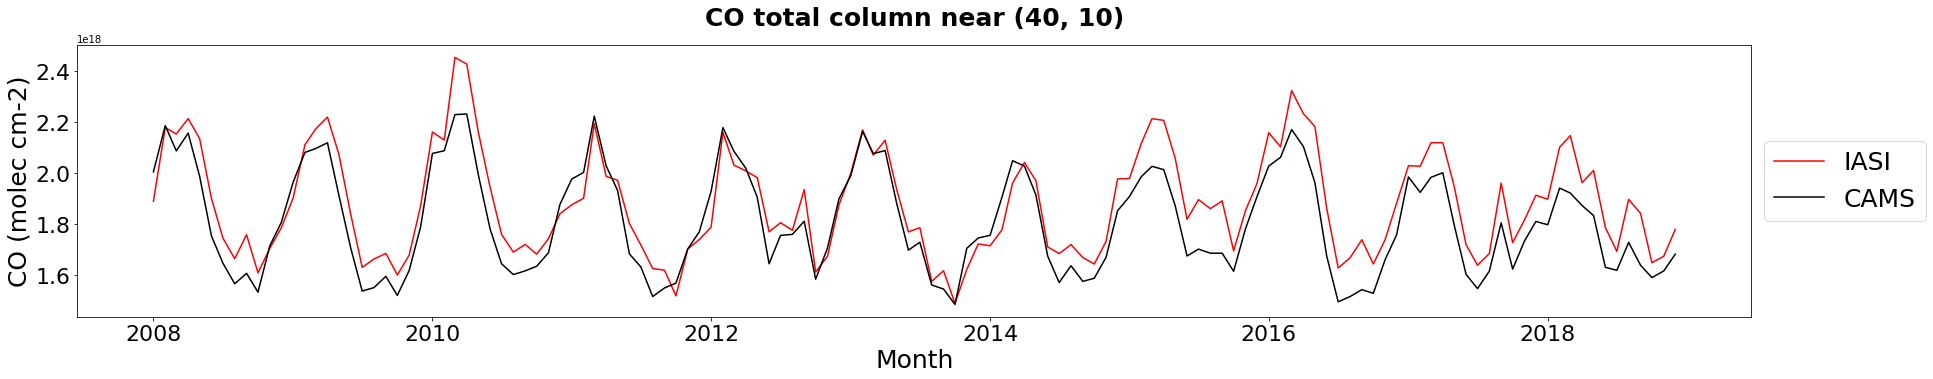

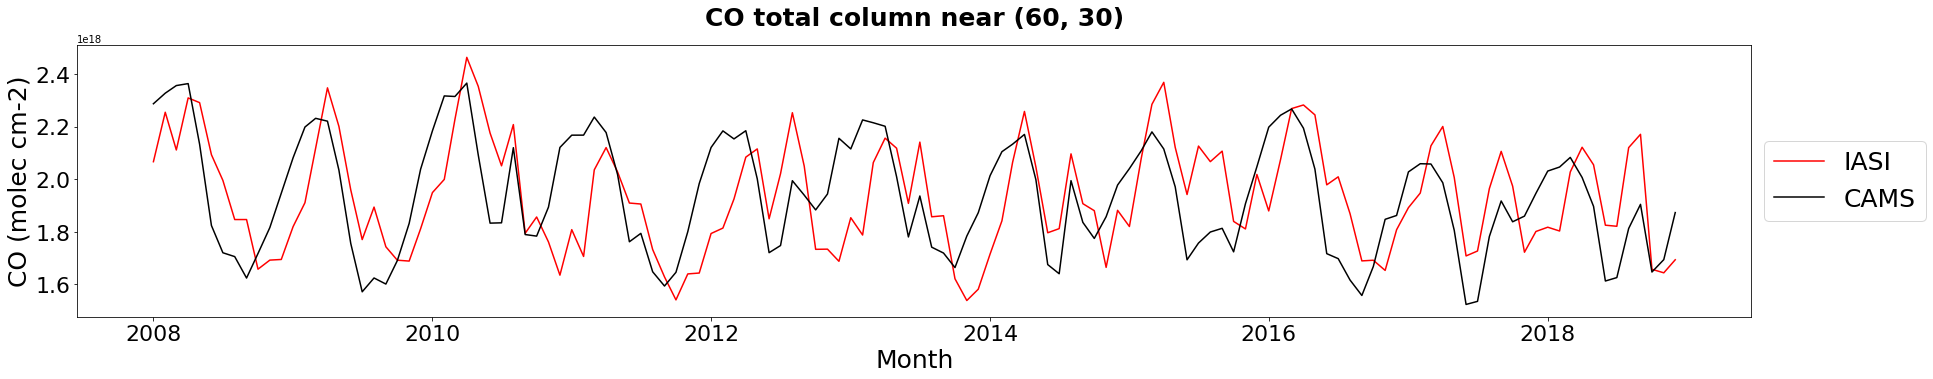

In [ ]:
coords_search_list = (50, 15,
                      40, 10,
                      60, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: CO_model = CO_sensor * 0.74 + (4.02E+17)
Coefficient of determination (R2): 0.60


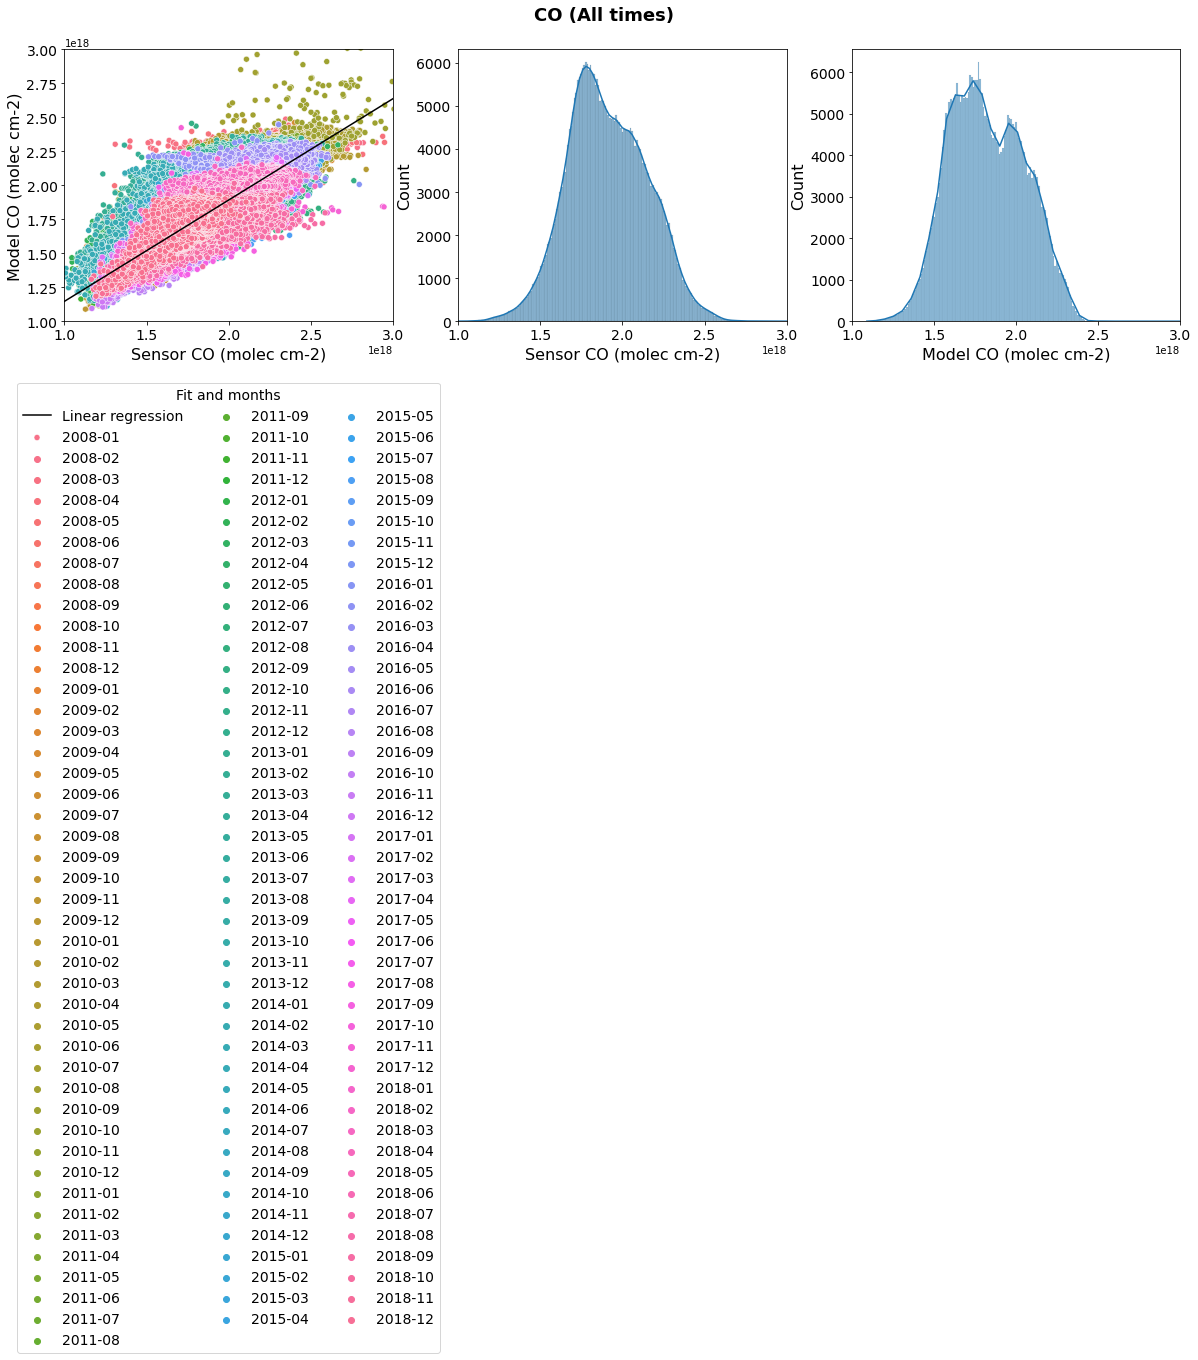

In [ ]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 3*10**18

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2008-01-01T00:00:00.000000000, 2008-02-01T00:...","((-25, 30), (45, 70))",0.600973,0.744918,4.015782e+17


## 9. Scatter plots by season

Fit equation: CO_model = CO_sensor * 0.74 + (4.02E+17)
Coefficient of determination (R2): 0.60


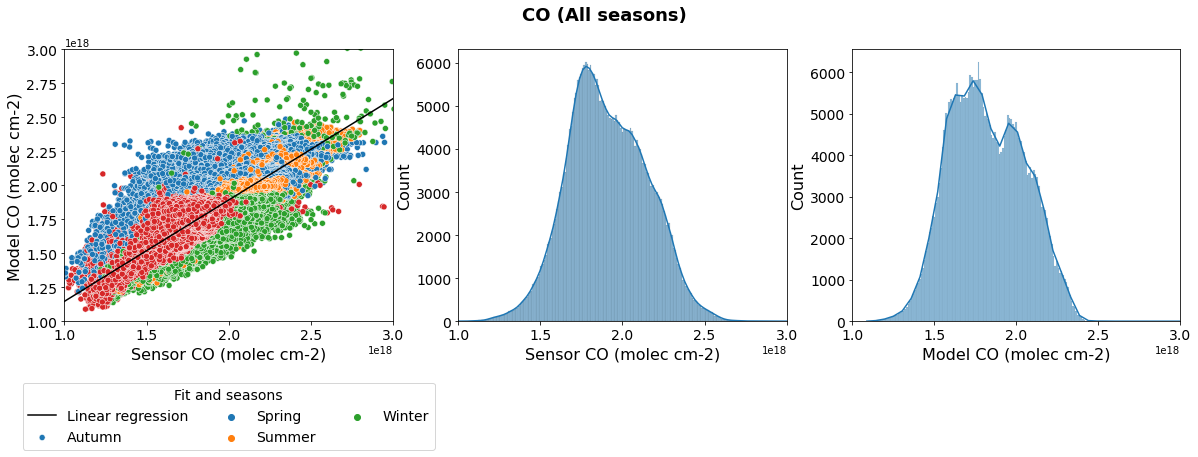

In [ ]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 3*10**18

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[Autumn, Spring, Summer, Winter]","((-25, 30), (45, 70))",0.600973,0.744918,4.015782e+17


## 10. Scatter plots by country (Google API required!)

In [ ]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']

lim_min = 1*10**18
lim_max = 3*10**18

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\n\nlim_min = 1*10**18\nlim_max = 3*10**18\n\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [ ]:
#summary